In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.style as style

In [2]:
df_corn = pd.read_csv("final_data_corn.csv")
df_rice = pd.read_csv("final_data_rice.csv")
df_spring_wheat = pd.read_csv("final_data_spring_wheat.csv")
df_winter_wheat = pd.read_csv("final_data_winter_wheat.csv")

In [3]:
df_list = [df_corn, df_rice, df_spring_wheat, df_winter_wheat]
filtered_columns = ['ID', 'state', 'population_world', 'cpi_us', 'co2(ppm)',
                    'oil_price', 'sunlight_svm', 'food_consumption_us(kcal)', 'productions']

In [4]:
for idx, df in enumerate(df_list):
		new_df = df.filter(filtered_columns, axis=1)
		new_df['year-state'] = new_df['ID'].str[:4] + new_df['state']
		new_df.drop(['ID', 'state'], axis=1, inplace=True)
		df_list[idx] = new_df


In [5]:
train_df_list = []
test_df_list = []

for df in df_list:
		unique_values = df_list[0]['year-state'].unique()
		train_num = int(len(unique_values) / 10 * 9)
		random_values = random.sample(list(unique_values), train_num)

		df_train = df_list[0][df_list[0]['year-state'].isin(random_values)]
		df_test = df_list[0][~df_list[0]['year-state'].isin(random_values)]
		train_df_list.append(df_train)
		test_df_list.append(df_test)

In [6]:
print(len(train_df_list[0]))
print(len(test_df_list[0]))
print(len(df_list[0]))

121260
13515
134775


In [7]:
from collections import defaultdict

def make_data(df):

    # 각 'target' 값에 대응하는 'X' 값을 저장하기 위한 딕셔너리 생성
		X_dict = defaultdict(list)
		for _, row in df.iterrows():
				X = row.drop(['productions', 'year-state']).tolist()
				year_state = row['year-state']
				X_dict[year_state].append(X)

		# X와 y 분리
		X = [X_dict[year_state] for year_state in df['year-state']]
		y = df['productions'].values.tolist()

		return X, y

In [ ]:
X_train, y_train = make_data(train_df_list[0])
print(X_train)

In [86]:
train_X_list = []
train_y_list = []

for train_df in train_df_list:
    X_train, y_train = make_data(train_df)
    train_X_list.append(X_train)
    train_y_list.append(y_train)
    
print(train_X_list[0])

In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [131]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y


# DataLoader로 데이터셋 생성
batch_size = 2
y_train = y_train  # y_train을 리스트로 변환
train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

In [132]:
class FieldCropsPredictionModel(nn.Module):
		def __init__(self, input_dim, feature_size, hidden_dim, layer_num=2):
				super(FieldCropsPredictionModel, self).__init__()
				self.filter_layer = nn.Linear(input_dim, 1, bias=True)
				self.hidden_layers = nn.ModuleList()
				self.output_layer = nn.Linear(hidden_dim, 1)
				nn.init.xavier_uniform_(self.filter_layer.weight)
				nn.init.xavier_uniform_(self.output_layer.weight)
				self.activation_function = nn.ReLU()

				for i in range(layer_num):
						self.hidden_layers.append(
								nn.Linear(feature_size if i == 0 else hidden_dim, hidden_dim))

		def forward(self, input):
				batch_size, sequence_length, feature_size = input.size()

				out = []
				for i in range(batch_size):
						sequence = input[i].t()
						sequence_out = self.filter_layer(sequence)
						sequence_out = self.activation_function(sequence_out)

						sequence_out = sequence_out.t()

						for layer in self.hidden_layers:
								sequence_out = layer(sequence_out)
								sequence_out = self.activation_function(sequence_out)

						sequence_out = self.output_layer(sequence_out)
						sequence_out = self.activation_function(sequence_out)
						
						out.append(sequence_out)

				out = torch.stack(out, dim=0)
				return out


In [133]:
def calculate_rmse(outputs, targets):
    mse = torch.mean((outputs - targets) ** 2)
    rmse = torch.sqrt(mse)
    return rmse

In [134]:
def train(model, dataloader, criterion, optim, scheduler, num_epochs):
		model.train()
		train_loss_list = []
		train_rmse_list = []

		for epoch in range(num_epochs):
				running_loss = 0.0
				running_rmse = 0.0
				
				for X, y in dataloader:
						outputs = model(X)
						loss = criterion(outputs, y)
						rmse = calculate_rmse(outputs, y)

						optim.zero_grad()
						loss.backward()
						optim.step()

						running_loss += loss.item()
						running_rmse += rmse.item()
						
				scheduler.step()

				epoch_loss = running_loss / len(dataloader.dataset)
				epoch_rmse = running_rmse / len(dataloader.dataset)

				print('Epoch [{}/{}], train_loss: {:.4f}, train_rmse: {:.4f}' .format(epoch +
				      1, num_epochs, epoch_loss, epoch_rmse))
				train_loss_list.append(torch.tensor(epoch_loss))
				train_rmse_list.append(torch.tensor(epoch_rmse))

		return model, train_loss_list, train_rmse_list


In [135]:
def validation(model, dataloader, criterion, num_epochs):
		model.eval()
		val_loss_list = []
		val_rmse_list = []

		for epoch in range(num_epochs):
				running_loss = 0.0
				running_rmse = 0.0

				for X, y in dataloader:
						outputs = model(X)
						loss = criterion(outputs, y)
						rmse = calculate_rmse(outputs, y)

						running_loss += loss.item()
						running_rmse += rmse.item()

				epoch_loss = running_loss / len(dataloader.dataset)
				epoch_rmse = running_rmse / len(dataloader.dataset)

				val_loss_list.append(torch.tensor(epoch_loss))
				val_rmse_list.append(torch.tensor(epoch_rmse))
		
		return model, val_loss_list, val_rmse_list


In [113]:
model = FieldCropsPredictionModel(12, 24, 15, 2)
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.MSELoss()

In [114]:
model_train, train_loss, train_rmse = train(
    model, train_dataloader, criterion, optimizer_ft, exp_lr_scheduler, 200)

# model_val, val_loss = validation(
#     model, val_loader, criterion, 50)

c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/200], train_loss: 0.0296, train_rmse: 0.1121
Epoch [2/200], train_loss: 0.0264, train_rmse: 0.1053
Epoch [3/200], train_loss: 0.0258, train_rmse: 0.1039
Epoch [4/200], train_loss: 0.0253, train_rmse: 0.1026
Epoch [5/200], train_loss: 0.0249, train_rmse: 0.1017
Epoch [6/200], train_loss: 0.0248, train_rmse: 0.1014
Epoch [7/200], train_loss: 0.0249, train_rmse: 0.1015
Epoch [8/200], train_loss: 0.0244, train_rmse: 0.1007
Epoch [9/200], train_loss: 0.0248, train_rmse: 0.1011
Epoch [10/200], train_loss: 0.0239, train_rmse: 0.0995
Epoch [11/200], train_loss: 0.0246, train_rmse: 0.1007
Epoch [12/200], train_loss: 0.0245, train_rmse: 0.1006
Epoch [13/200], train_loss: 0.0243, train_rmse: 0.1005
Epoch [14/200], train_loss: 0.0246, train_rmse: 0.1009
Epoch [15/200], train_loss: 0.0248, train_rmse: 0.1008
Epoch [16/200], train_loss: 0.0239, train_rmse: 0.0999
Epoch [17/200], train_loss: 0.0236, train_rmse: 0.0989
Epoch [18/200], train_loss: 0.0248, train_rmse: 0.1014
Epoch [19/200], tra

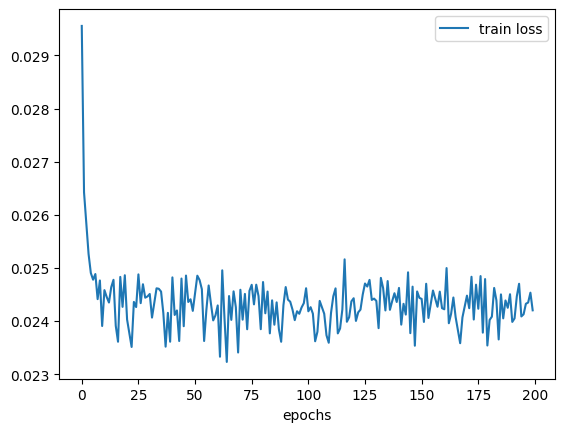

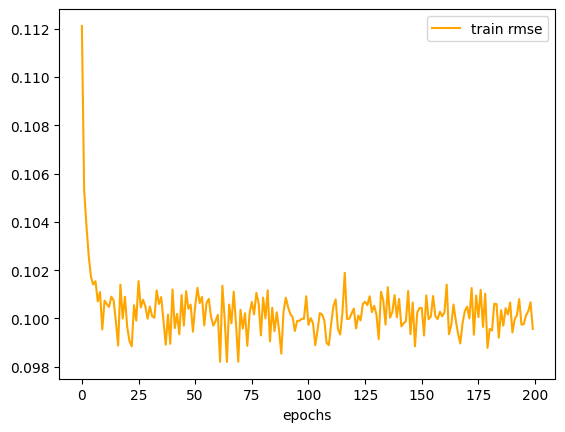

In [122]:
x = range(len(train_loss))
y_loss = [loss.detach().numpy() for loss in train_loss]  # .detach().numpy() 사용

plt.plot(x, y_loss, label='train loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.show()

x = range(len(train_rmse))
y_rmse = [rmse.detach().numpy() for rmse in train_rmse]  # .detach().numpy() 사용

plt.plot(x, y_rmse, color='orange', label='train rmse')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.show()


Fold 1


c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], train_loss: 0.0950, train_rmse: 0.1976
Epoch [2/50], train_loss: 0.0950, train_rmse: 0.1979
Epoch [3/50], train_loss: 0.0950, train_rmse: 0.1974
Epoch [4/50], train_loss: 0.0950, train_rmse: 0.1981
Epoch [5/50], train_loss: 0.0950, train_rmse: 0.1980
Epoch [6/50], train_loss: 0.0950, train_rmse: 0.1968
Epoch [7/50], train_loss: 0.0950, train_rmse: 0.1977
Epoch [8/50], train_loss: 0.0950, train_rmse: 0.1978
Epoch [9/50], train_loss: 0.0950, train_rmse: 0.1976
Epoch [10/50], train_loss: 0.0950, train_rmse: 0.1977
Epoch [11/50], train_loss: 0.0950, train_rmse: 0.1975
Epoch [12/50], train_loss: 0.0950, train_rmse: 0.1971
Epoch [13/50], train_loss: 0.0950, train_rmse: 0.1973
Epoch [14/50], train_loss: 0.0950, train_rmse: 0.1982
Epoch [15/50], train_loss: 0.0950, train_rmse: 0.1977
Epoch [16/50], train_loss: 0.0950, train_rmse: 0.1975
Epoch [17/50], train_loss: 0.0950, train_rmse: 0.1973
Epoch [18/50], train_loss: 0.0950, train_rmse: 0.1976
Epoch [19/50], train_loss: 0.0950, tr

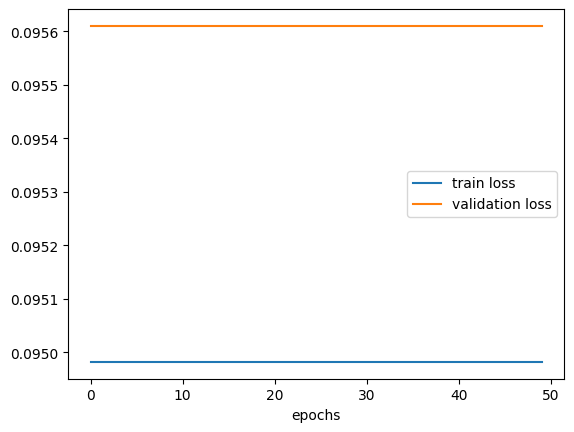

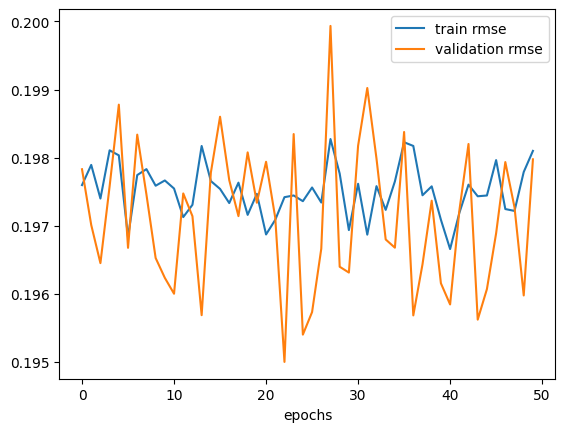

Fold 2


c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], train_loss: 0.0312, train_rmse: 0.1148
Epoch [2/50], train_loss: 0.0272, train_rmse: 0.1075
Epoch [3/50], train_loss: 0.0268, train_rmse: 0.1066
Epoch [4/50], train_loss: 0.0263, train_rmse: 0.1055
Epoch [5/50], train_loss: 0.0257, train_rmse: 0.1042
Epoch [6/50], train_loss: 0.0263, train_rmse: 0.1051
Epoch [7/50], train_loss: 0.0254, train_rmse: 0.1038
Epoch [8/50], train_loss: 0.0258, train_rmse: 0.1039
Epoch [9/50], train_loss: 0.0255, train_rmse: 0.1034
Epoch [10/50], train_loss: 0.0255, train_rmse: 0.1031
Epoch [11/50], train_loss: 0.0248, train_rmse: 0.1021
Epoch [12/50], train_loss: 0.0262, train_rmse: 0.1045
Epoch [13/50], train_loss: 0.0255, train_rmse: 0.1037
Epoch [14/50], train_loss: 0.0254, train_rmse: 0.1034
Epoch [15/50], train_loss: 0.0254, train_rmse: 0.1031
Epoch [16/50], train_loss: 0.0254, train_rmse: 0.1035
Epoch [17/50], train_loss: 0.0250, train_rmse: 0.1024
Epoch [18/50], train_loss: 0.0248, train_rmse: 0.1017
Epoch [19/50], train_loss: 0.0249, tr

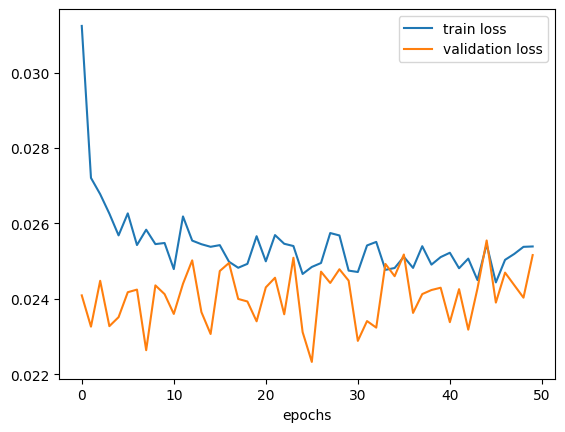

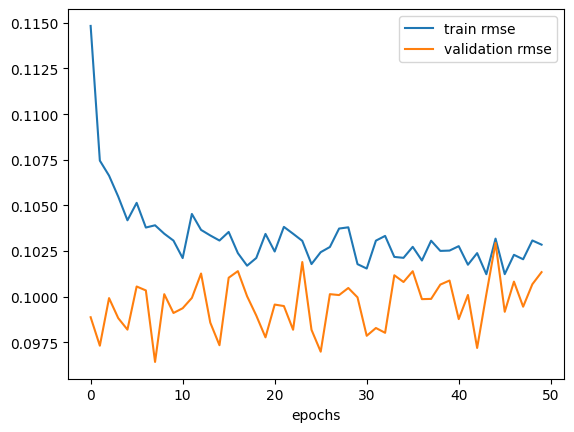

Fold 3
Epoch [1/50], train_loss: 0.0296, train_rmse: 0.1122
Epoch [2/50], train_loss: 0.0273, train_rmse: 0.1071
Epoch [3/50], train_loss: 0.0268, train_rmse: 0.1059
Epoch [4/50], train_loss: 0.0262, train_rmse: 0.1045
Epoch [5/50], train_loss: 0.0259, train_rmse: 0.1041
Epoch [6/50], train_loss: 0.0261, train_rmse: 0.1040
Epoch [7/50], train_loss: 0.0261, train_rmse: 0.1045
Epoch [8/50], train_loss: 0.0249, train_rmse: 0.1017
Epoch [9/50], train_loss: 0.0254, train_rmse: 0.1032
Epoch [10/50], train_loss: 0.0251, train_rmse: 0.1026
Epoch [11/50], train_loss: 0.0249, train_rmse: 0.1023
Epoch [12/50], train_loss: 0.0251, train_rmse: 0.1025
Epoch [13/50], train_loss: 0.0250, train_rmse: 0.1022
Epoch [14/50], train_loss: 0.0246, train_rmse: 0.1011
Epoch [15/50], train_loss: 0.0248, train_rmse: 0.1010
Epoch [16/50], train_loss: 0.0250, train_rmse: 0.1020
Epoch [17/50], train_loss: 0.0251, train_rmse: 0.1022
Epoch [18/50], train_loss: 0.0248, train_rmse: 0.1017
Epoch [19/50], train_loss: 0.0

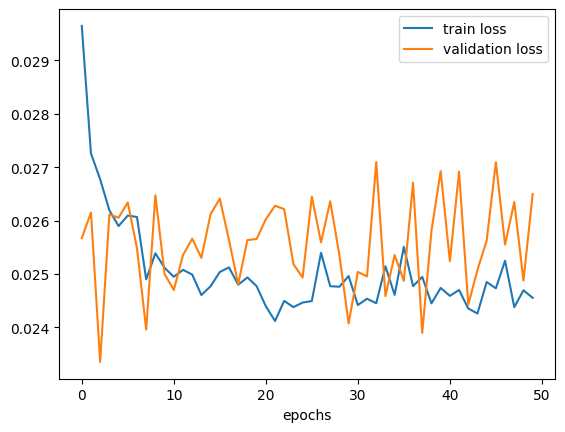

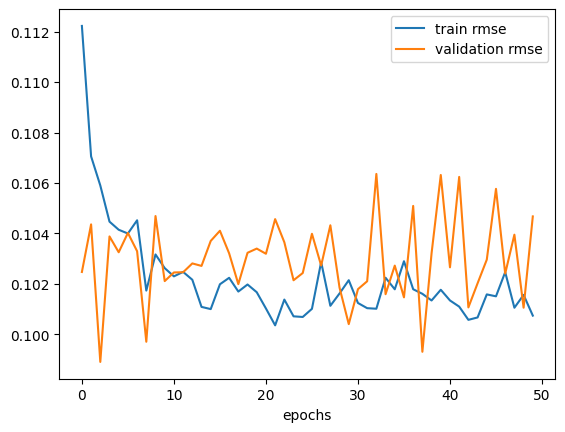

Fold 4
Epoch [1/50], train_loss: 0.0958, train_rmse: 0.1979
Epoch [2/50], train_loss: 0.0957, train_rmse: 0.1982
Epoch [3/50], train_loss: 0.0957, train_rmse: 0.1977
Epoch [4/50], train_loss: 0.0957, train_rmse: 0.1984
Epoch [5/50], train_loss: 0.0957, train_rmse: 0.1984
Epoch [6/50], train_loss: 0.0957, train_rmse: 0.1984
Epoch [7/50], train_loss: 0.0957, train_rmse: 0.1974
Epoch [8/50], train_loss: 0.0957, train_rmse: 0.1977
Epoch [9/50], train_loss: 0.0957, train_rmse: 0.1978
Epoch [10/50], train_loss: 0.0957, train_rmse: 0.1974
Epoch [11/50], train_loss: 0.0957, train_rmse: 0.1976
Epoch [12/50], train_loss: 0.0957, train_rmse: 0.1984
Epoch [13/50], train_loss: 0.0957, train_rmse: 0.1975
Epoch [14/50], train_loss: 0.0957, train_rmse: 0.1985
Epoch [15/50], train_loss: 0.0957, train_rmse: 0.1972
Epoch [16/50], train_loss: 0.0957, train_rmse: 0.1985
Epoch [17/50], train_loss: 0.0957, train_rmse: 0.1984
Epoch [18/50], train_loss: 0.0957, train_rmse: 0.1976
Epoch [19/50], train_loss: 0.0

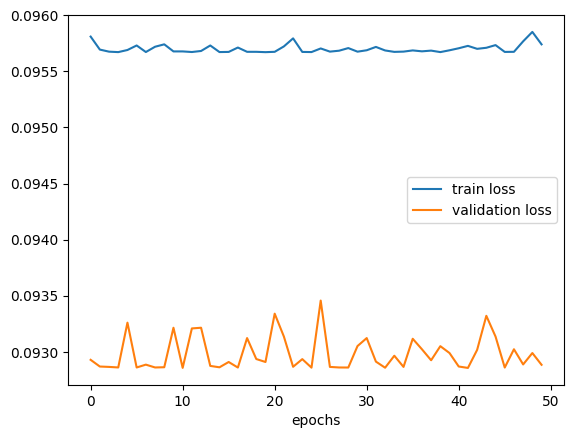

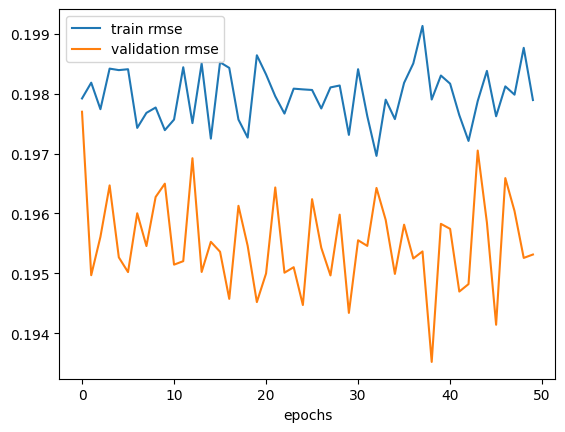

Fold 5
Epoch [1/50], train_loss: 0.0278, train_rmse: 0.1076
Epoch [2/50], train_loss: 0.0266, train_rmse: 0.1057
Epoch [3/50], train_loss: 0.0261, train_rmse: 0.1043
Epoch [4/50], train_loss: 0.0262, train_rmse: 0.1051
Epoch [5/50], train_loss: 0.0257, train_rmse: 0.1035
Epoch [6/50], train_loss: 0.0256, train_rmse: 0.1025
Epoch [7/50], train_loss: 0.0259, train_rmse: 0.1039
Epoch [8/50], train_loss: 0.0247, train_rmse: 0.1011
Epoch [9/50], train_loss: 0.0244, train_rmse: 0.1008
Epoch [10/50], train_loss: 0.0245, train_rmse: 0.1004
Epoch [11/50], train_loss: 0.0254, train_rmse: 0.1023
Epoch [12/50], train_loss: 0.0242, train_rmse: 0.1004
Epoch [13/50], train_loss: 0.0248, train_rmse: 0.1011
Epoch [14/50], train_loss: 0.0246, train_rmse: 0.1008
Epoch [15/50], train_loss: 0.0248, train_rmse: 0.1011
Epoch [16/50], train_loss: 0.0243, train_rmse: 0.1001
Epoch [17/50], train_loss: 0.0242, train_rmse: 0.1006
Epoch [18/50], train_loss: 0.0247, train_rmse: 0.1008
Epoch [19/50], train_loss: 0.0

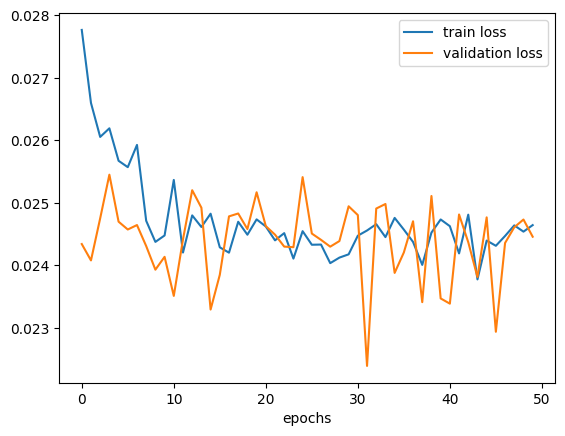

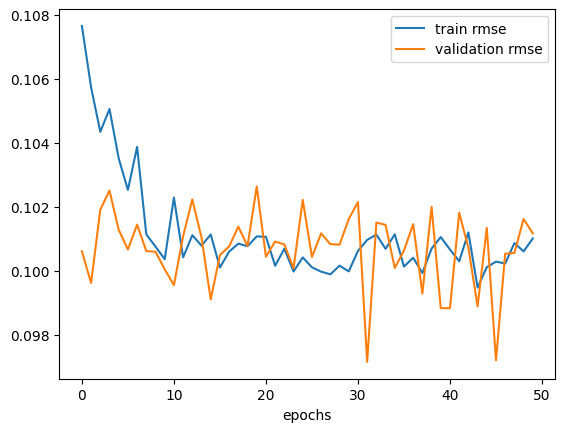

In [141]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_count = 1
for train_index, val_index in kf.split(X):
		X_train_fold = [X[i] for i in train_index]
		y_train_fold = [y[i] for i in train_index]
		X_val_fold = [X[i] for i in val_index]
		y_val_fold = [y[i] for i in val_index]

		train_dataset = CustomDataset(X_train_fold, y_train_fold)
		train_dataloader = DataLoader(
				train_dataset, batch_size=batch_size, shuffle=True)

		val_dataset = CustomDataset(X_val_fold, y_val_fold)
		val_dataloader = DataLoader(
				val_dataset, batch_size=batch_size, shuffle=True)

		model = FieldCropsPredictionModel(12, 24, 15, 2)
		optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
		exp_lr_scheduler = optim.lr_scheduler.StepLR(
				optimizer_ft, step_size=7, gamma=0.1)
		criterion = nn.MSELoss()

		print(f"Fold {fold_count}")
		fold_count += 1
		model_train, train_loss, train_rmse = train(
				model, train_dataloader, criterion, optimizer_ft, exp_lr_scheduler, 50)
		model_val, val_loss, val_rmse = validation(model, val_dataloader, criterion, 50)

		x = range(len(train_loss))
		y_train_loss = [loss.detach().numpy() for loss in train_loss]
		plt.plot(x, y_train_loss, label='train loss')

		y_val_loss = [loss.detach().numpy() for loss in val_loss]
		plt.plot(x, y_val_loss, label='validation loss')

		plt.legend(loc='best')
		plt.xlabel('epochs')
		plt.show()

		x = range(len(train_rmse))
		y_train_rmse = [rmse.detach().numpy() for rmse in train_rmse]
		plt.plot(x, y_train_rmse, label='train rmse')

		y_val_rmse = [rmse.detach().numpy() for rmse in val_rmse]
		plt.plot(x, y_val_rmse, label='validation rmse')

		plt.legend(loc='best')
		plt.xlabel('epochs')
		plt.show()
